In [46]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb

In [47]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'

___

# Applied Machine Learning 2024: *Initial Project*
#### *Niels August Daivdsen (phx657)*
___

## Second part: Making regression to estimate the energy of electrons in dataset 1


In [48]:
# Load the data
data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")

# Slicing the data for only electrons
input_data = data[data['p_Truth_isElectron'] == 1]
energy_data = input_data['p_Truth_Energy']
input_data = input_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
variables = input_data.columns.tolist()

test_data = pd.read_csv("AppMl_InitialProject_test_classification.csv", sep=",")

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(input_data, energy_data, test_size=0.2, random_state=42)


### Using SHAP values and Permutation Importance to determine the top 12 important features

In [ ]:
# Training a regression model on all varaibles (LGBM)

params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'max_depth': 10,
        'num_leaves': 30,
        'learning_rate': 0.07,
        'min_data_in_leaf': 76,
        'n_estimators': 1000,
        'verbose': -1,
        'early_stopping_rounds': 20
}
reg_model = lgb.LGBMRegressor(**params)
model = reg_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])





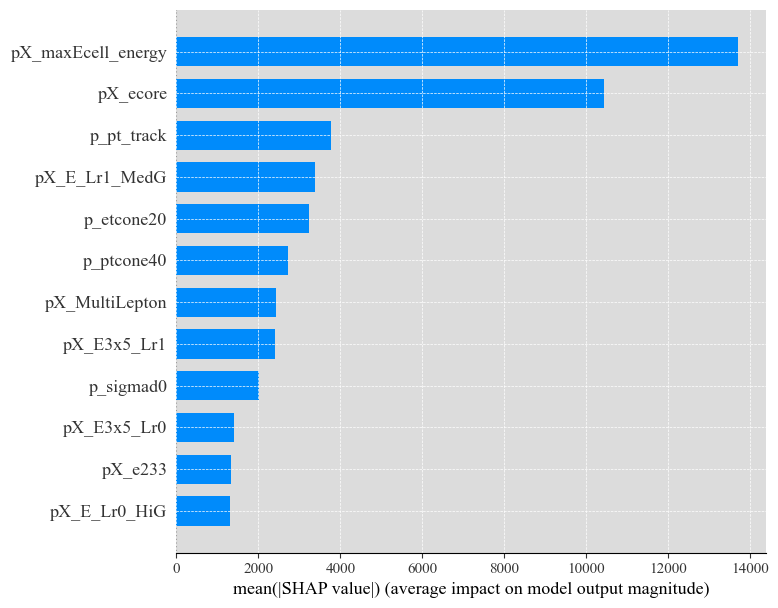

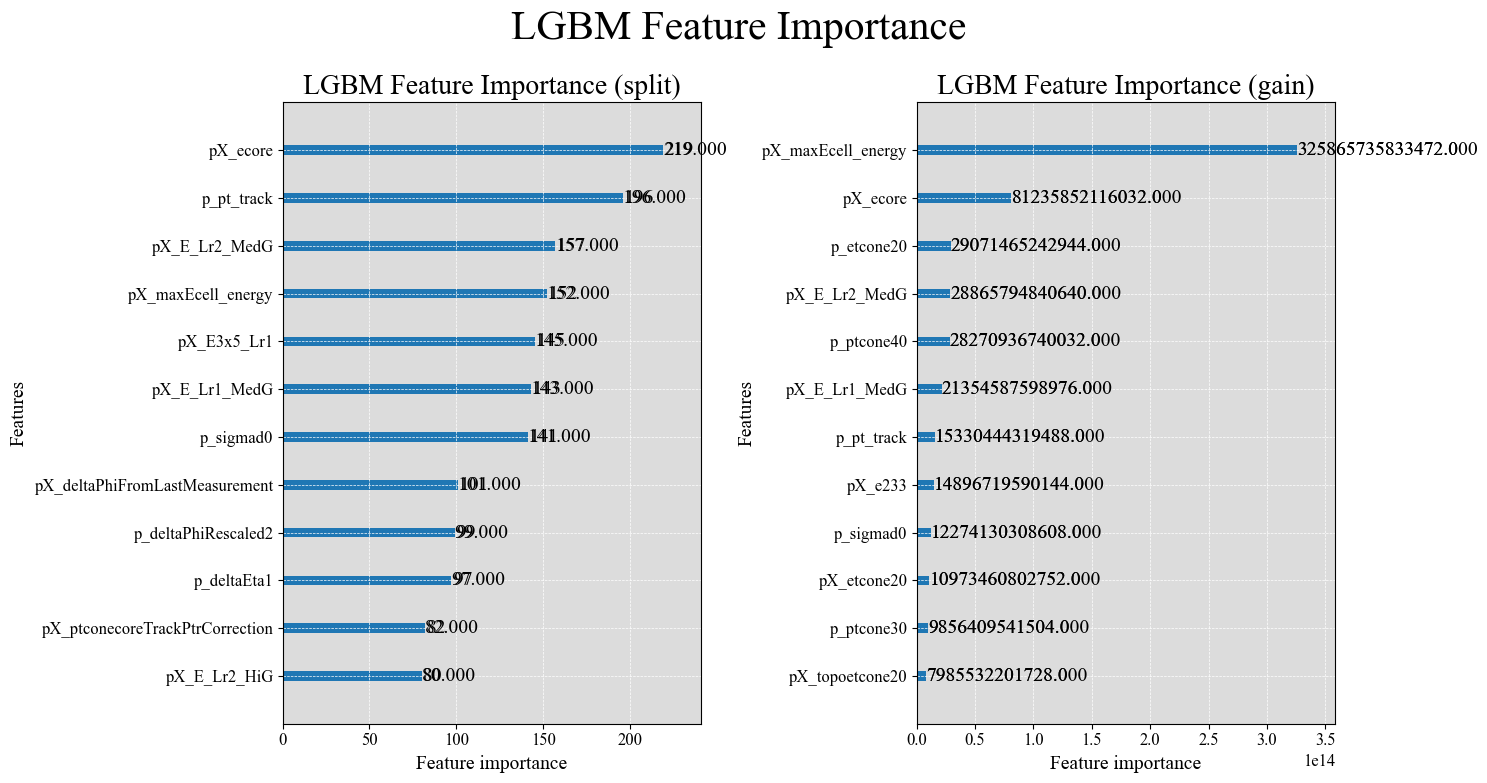

In [50]:
from sklearn.inspection import permutation_importance
import shap

# SHAP values
fig = plt.figure(figsize=(15, 8))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, 
                  X_valid, 
                  feature_names=variables, 
                  plot_type="bar",
                  max_display=12, 
                  color_bar=True)

# LGBM feature importance
fig, ax = plt.subplots(1,2,figsize=(15, 8))
lgb.plot_importance(model, 
                     max_num_features=12, 
                     importance_type='split', 
                     ax=ax[0], 
                     title="LGBM Feature Importance (split)",
                     precision=1)

lgb.plot_importance(model,
                     max_num_features=12, 
                     importance_type='gain', 
                     ax=ax[1], 
                     title="LGBM Feature Importance (gain)",
                     precision=1)


for axi in ax:
    for p in axi.patches:
        width = p.get_width()
        axi.text(width + 0.01,           # x-position
                p.get_y() + p.get_height() / 2,  # y-position
                f"{width:.3f}",         # rounded label
                va='center')


fig.suptitle("LGBM Feature Importance", fontsize=30)
plt.tight_layout()

# Extracting top 12 features from SHAP values
shap_importance = pd.DataFrame(list(zip(variables, np.abs(shap_values).mean(axis=0))), 
                                columns=["Feature", "SHAP_Importance"])
shap_top12 = shap_importance.sort_values(by="SHAP_Importance", ascending=False).head(12)



# Extracting top 12 features from LGBM gain plot
lbg_importance = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

lgb_importance = pd.DataFrame({
    "Feature": feature_names,
    "LGBM_Gain_importance": lbg_importance
})
lgb_top12 = lgb_importance.sort_values(by="LGBM_Gain_importance", ascending=False).head(12)

# Merging the two dataframes
importance_df = pd.merge(shap_top12, lgb_top12, on="Feature", how="outer")



In [53]:
importance_df = importance_df.sort_values(by="LGBM_Gain_importance", ascending=False)
LGBM_top12_features = importance_df[importance_df['LGBM_Gain_importance'].notna()]['Feature'].tolist()

importance_df = importance_df.sort_values(by="SHAP_Importance", ascending=False)
SHAP_top12_features = importance_df[importance_df['SHAP_Importance'].notna()]['Feature'].tolist()


### LightGBM regression on top 12 varaibles

RMSE: 17629.040
MAE: 7911.357
MSE: 310783058.248


Text(0.5, 1.0, 'LGBM Regression Model with Top 12 Features')

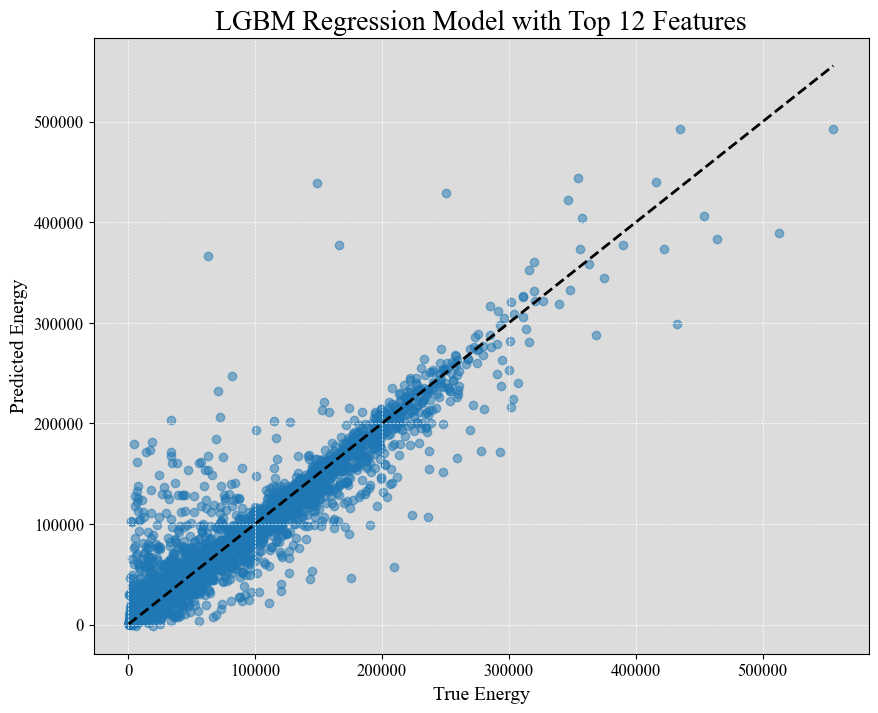

In [55]:
# LightGBM regression model with top 12 features
data_top12s = input_data[SHAP_top12_features]
X_train, X_valid, y_train, y_valid = train_test_split(data_top12s, energy_data, test_size=0.2, random_state=42)

reg_model_top12s = lgb.LGBMRegressor(**params)
model_fit_top12s = reg_model_top12s.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

# Evalutating the model
y_pred = model_fit_top12s.predict(X_valid)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title("LGBM Regression Model with Top 12 Features")


In [ ]:
# Optuna HPO
import optuna


def objective(trial):
    params = {
        'obejctive': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'verbose': -1,
        'early_stopping_rounds': 20
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value:.3f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-14 11:12:48,867] A new study created in memory with name: no-name-2b4b70f6-5854-401e-9c5a-2ca4137747db
[I 2025-05-14 11:12:49,731] Trial 0 finished with value: 315612513.7763737 and parameters: {'num_leaves': 22, 'max_depth': 8, 'learning_rate': 0.031536500853437906, 'min_data_in_leaf': 92, 'n_estimators': 289}. Best is trial 0 with value: 315612513.7763737.
[I 2025-05-14 11:12:50,086] Trial 1 finished with value: 321325801.0355556 and parameters: {'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.15479187640473455, 'min_data_in_leaf': 65, 'n_estimators': 155}. Best is trial 0 with value: 315612513.7763737.
[I 2025-05-14 11:12:51,461] Trial 2 finished with value: 311846254.67073125 and parameters: {'num_leaves': 90, 'max_depth': 16, 'learning_rate': 0.05123041474898899, 'min_data_in_leaf': 58, 'n_estimators': 578}. Best is trial 2 with value: 311846254.67073125.
[I 2025-05-14 11:12:52,040] Trial 3 finished with value: 318642521.647443 and parameters: {'num_leaves': 55, '

Best trial:
  RMSE: 305133021.499
  Best hyperparameters:
    num_leaves: 93
    max_depth: 8
    learning_rate: 0.050816069402471006
    min_data_in_leaf: 78
    n_estimators: 905


Optimized RMSE: 17468.057
Optimized MAE: 7821.674
Optimized MSE: 305133021.499


Text(0.5, 1.0, 'LGBM Regression Model with Optimized Hyperparameters')

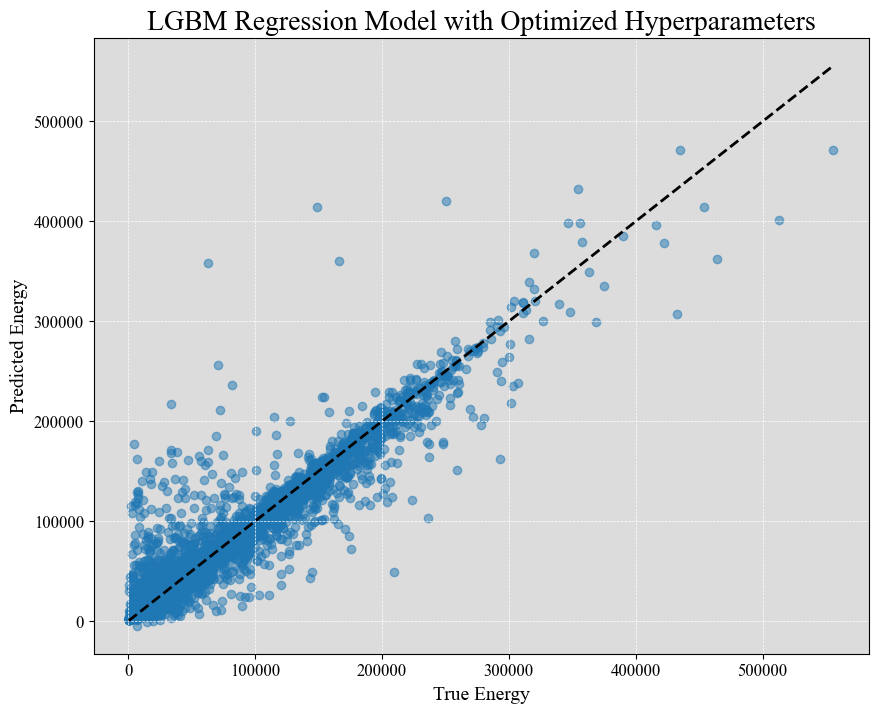

In [ ]:
opt_params = trial.params
opt_params['objective'] = 'regression'
opt_params['boosting_type'] = 'gbdt'
opt_params['metric'] = 'rmse'
opt_params['verbose'] = -1
opt_params['early_stopping_rounds'] = 20

# Retrain the model with the optimized parameters
reg_model_opt = lgb.LGBMRegressor(**opt_params)
model_opt = reg_model_opt.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
y_pred_opt = model_opt.predict(X_valid)


mse_opt = mean_squared_error(y_valid, y_pred_opt)
mae_opt = mean_absolute_error(y_valid, y_pred_opt)
rmse_opt = np.sqrt(mse_opt)

print(f"Optimized RMSE: {rmse_opt:.3f}")
print(f"Optimized MAE: {mae_opt:.3f}")
print(f"Optimized MSE: {mse_opt:.3f}")
# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, y_pred_opt, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title("LGBM Regression Model with Optimized Hyperparameters")


### Trying the optimized LGBM model on the test data



### Regression Neural Network using PyTorch


In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)